In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import cv2 as cv

  #Setting all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=5

   #making a check to find out if I am in the right folder 

In [3]:
data_dir = "cancer_dataset"

In [4]:
os.listdir(data_dir)

['basal_cell_carcinoma',
 'melanoma',
 'not_cancerous',
 'squamous_cell_carcinoma']

In [5]:
for image_class in os.listdir(data_dir):
    print(image_class)

basal_cell_carcinoma
melanoma
not_cancerous
squamous_cell_carcinoma


#Import data into tensorflow dataset object 


In [6]:
dataset = tf.keras.utils.image_dataset_from_directory("cancer_dataset")

Found 4000 files belonging to 4 classes.


In [7]:
class_names = dataset.class_names
class_names

['basal_cell_carcinoma',
 'melanoma',
 'not_cancerous',
 'squamous_cell_carcinoma']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 2 0 1 2 3 3 1 0 0 0 3 3 0 2 2 1 1 1 2 3 2 3 0 2 2 1 1 2 2 3 0]


 #As we can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels


 #Visualizing some of the images from our dataset

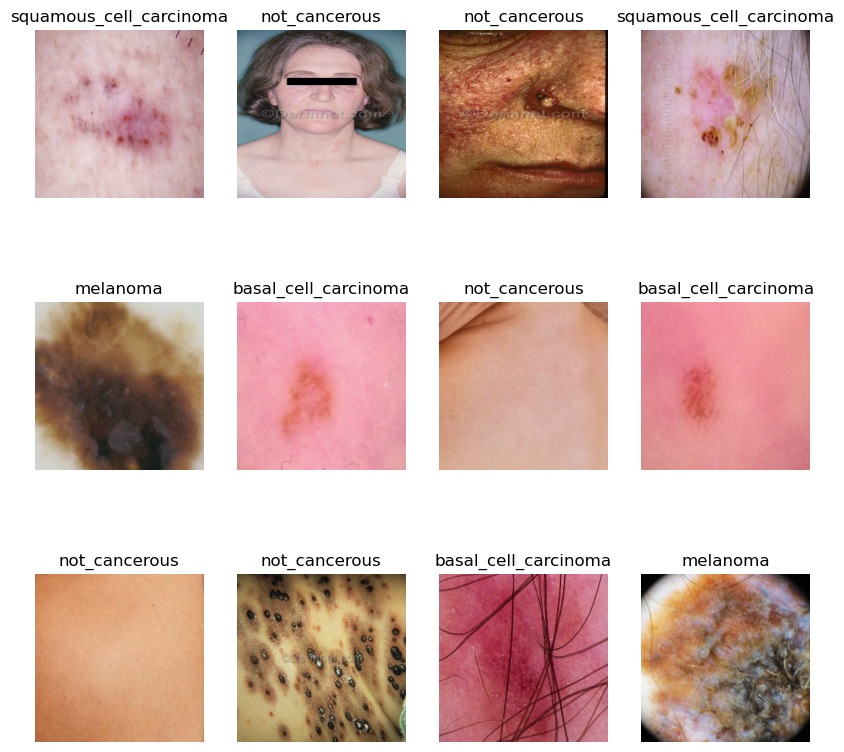

In [9]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i +1 )
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
len(dataset)

125

#Function to Split Dataset into

#1. Training
#2. Validation
 #3. Test

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
len(test_ds)

13

##Cache, Shuffle, and Prefetch the Dataset

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

 #Building the Model

#Creating a Layer for Resizing and Normalization


In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

 #Data Augmentation


In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#Applying Data Augmentation to Train Dataset

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

#Model Architecture


In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

##Compiling the Model
#We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [20]:
model.compile(
    optimizer='adam',
  #  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
##Time to train the model by using the model.fit

In [22]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)


Epoch 1/5
100/100 [==============================] - 308s 3s/step - loss: 0.9519 - accuracy: 0.5863 - val_loss: 0.5582 - val_accuracy: 0.8073
Epoch 2/5
100/100 [==============================] - 276s 3s/step - loss: 0.5577 - accuracy: 0.7994 - val_loss: 0.4646 - val_accuracy: 0.8542
Epoch 3/5
100/100 [==============================] - 277s 3s/step - loss: 0.4317 - accuracy: 0.8525 - val_loss: 0.3393 - val_accuracy: 0.8828
Epoch 4/5
100/100 [==============================] - 277s 3s/step - loss: 0.4410 - accuracy: 0.8516 - val_loss: 0.3903 - val_accuracy: 0.8568
Epoch 5/5
100/100 [==============================] - 276s 3s/step - loss: 0.3967 - accuracy: 0.8656 - val_loss: 0.3800 - val_accuracy: 0.8646


In [23]:
# Performance evaluation metrics

#recision, Recall, F1 & Accuracy

In [24]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np

In [25]:
#for batch in test_ds.as_numpy_iterator():
#    X, y = batch
  #  y_r = y.reshape(-1,)
  #  print(y_r[:4])
   # y_pred = model.predict(X)
   # y_pred_classes = [np.argmax(element) for element in y_pred]
   # print("classification report:\n", classification_report(y_r, y_pred_classes))


In [26]:
batch = next(test_ds.as_numpy_iterator())
X,y = batch
y_r =y.reshape(-1,)
print(y_r[:4])
y_pred= model.predict(X)
y_pred_classes =[np.argmax(element) for element in y_pred]
print("classification report:\n", classification_report(y_r,y_pred_classes))

[3 3 3 1]
1/1 [==============================] - 1s 701ms/step
classification report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.83      0.91        12
           2       0.57      1.00      0.73         4
           3       1.00      0.78      0.88         9

    accuracy                           0.88        32
   macro avg       0.86      0.90      0.86        32
weighted avg       0.92      0.88      0.88        32



#evaluation

In [27]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 8s 658ms/step - loss: 0.4095 - accuracy: 0.8558


In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 100}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
history.history['loss'][:5] 

[0.9519051909446716,
 0.5577062368392944,
 0.43165263533592224,
 0.4410135746002197,
 0.3966514468193054]

#Plotting the Accuracy and Loss Curves

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

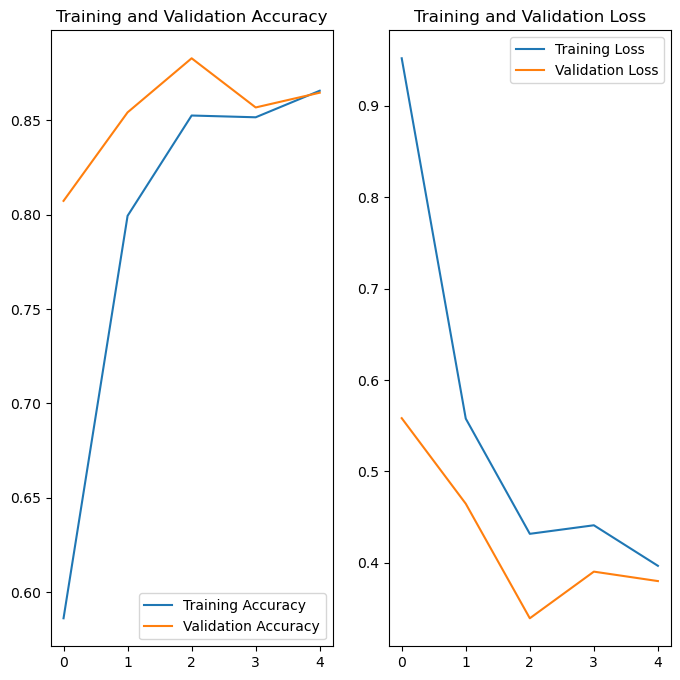

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Run prediction on a sample image

first image to predict
actual label: squamous_cell_carcinoma
1/1 [==============================] - 1s 546ms/step
predicted label: not_cancerous


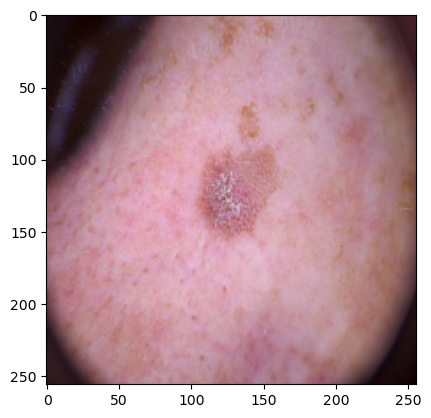

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

#Write a function for inference

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#Running inference on few sample images

1/1 [==============================] - 0s 49ms/step


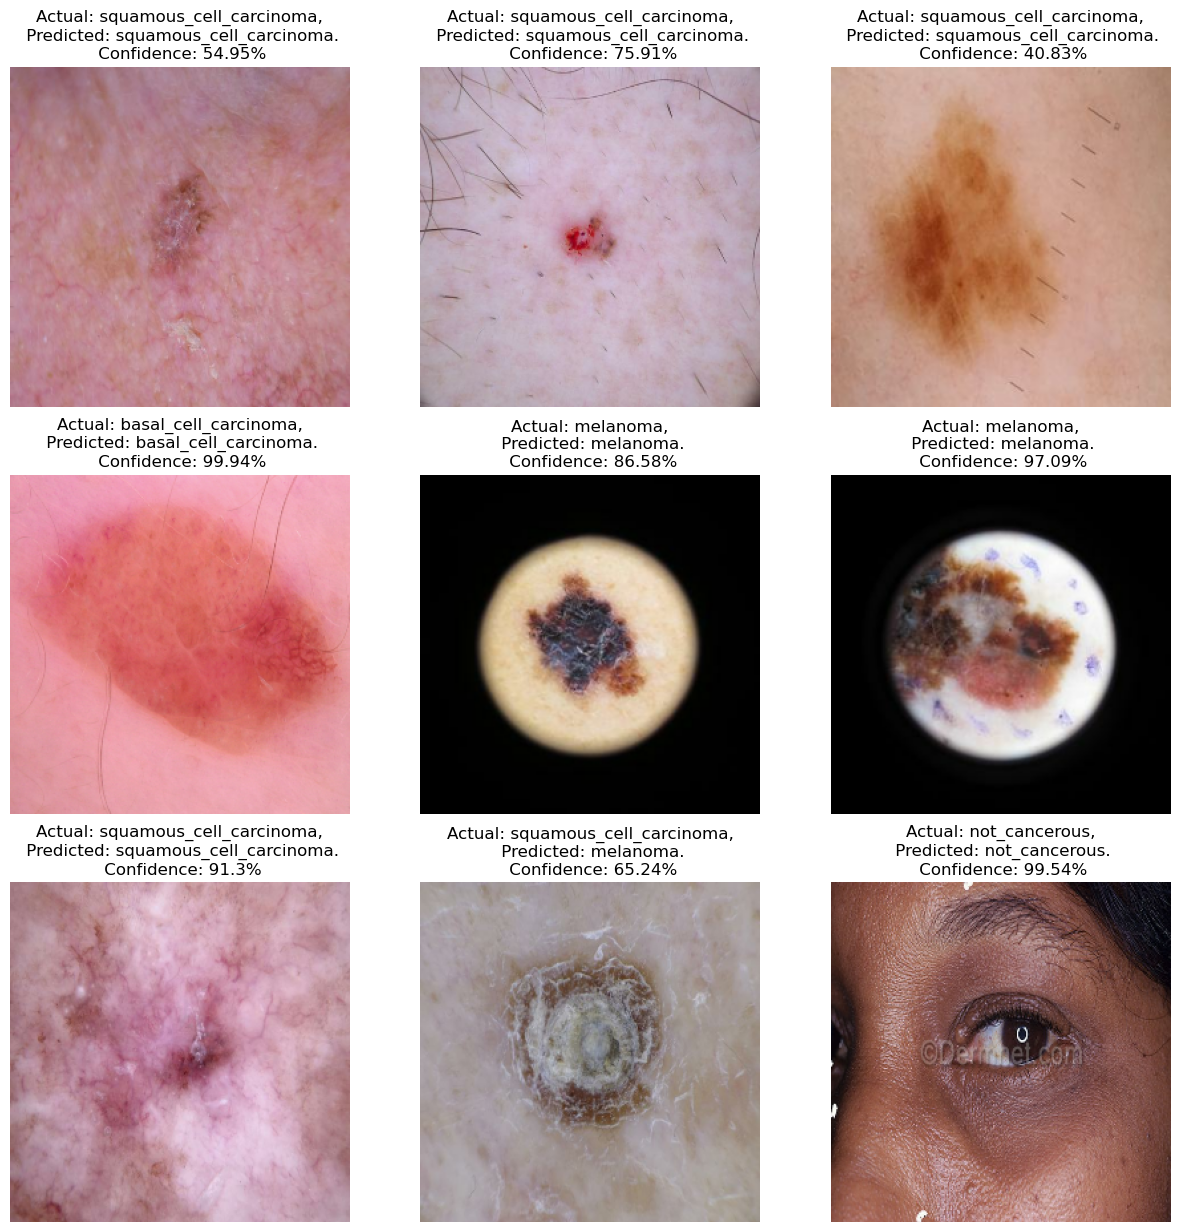

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [2]:
model.save("skin")

NameError: name 'model' is not defined

In [38]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("skinn") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('modthtrl.tflite', 'wb') as f:
  f.write(tflite_model)

OSError: SavedModel file does not exist at: skinn\{saved_model.pbtxt|saved_model.pb}